## Took EDA and preprocessing pipeline from here: 

https://www.kaggle.com/code/venkatapadavala/house-prices-advanced-regression-practice

In [274]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import pandas as pd
import statsmodels.api as sm

%matplotlib inline
pd.options.display.max_rows = 500

In [275]:
train_path = '../house_prices/train.csv'
test_path = '../house_prices/test.csv'

In [276]:
train_data = pd.read_csv(train_path, index_col='Id')
test_data = pd.read_csv(test_path, index_col='Id')

In [277]:
target = 'SalePrice'
features = list(train_data.columns[:-1])

train_data = train_data[[target] + features]

In [278]:
train_data.head()

,SalePrice,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,
1,208500,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
2,181500,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
3,223500,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
4,140000,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
5,250000,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal


## Let's look at the data:

In [279]:
train_data.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1460 entries, 1 to 1460
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   SalePrice      1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

Для наивного байесовского классификатора мы предпологаем незаивисимость всех фичей, в случае же с простыми линейными моделями достаточным условием хорошей работы модели является то, что каждая фича распределена нормально, однако для деревьев нам не надо делать никаких из этих предположений. Нам стоит лишь посмотреть на то как распределен таргет и является ли выборка сбалансированной.

kde - kernel density estimation - по конечному числу точек аппроксимируем распределение непрерывной случайной величины

В sns существует два типа графиков: axes-level functions, figure-level functions. Matplotlib устроен так, что самое главное - это figure.

Функция displot создает фигуру, когда мы ее вызываем, а на ней создает 1 axes, где уже все и строит, при вызове функции ей можно указать height и aspect - чтобы задать figsize для матплолибовского plt.figure, на котором находится график

In [280]:
import statistics

y = np.array(train_data[target]).astype(float)
y.sort()
mu = statistics.mean(y)
sigma = statistics.stdev(y)

p = stats.norm.pdf(y, mu, sigma)

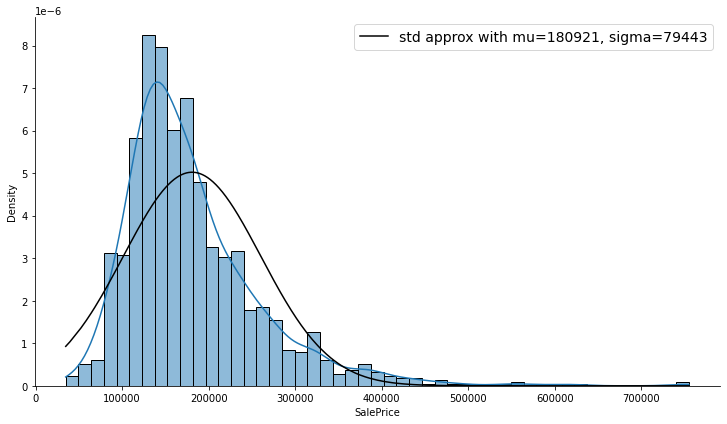

In [281]:
fig = sns.displot(data=train_data[target], kde=True, stat='density', height=6, aspect=1.7)

plt.plot(y, p, color='black', label=f'std approx with mu={round(mu)}, sigma={round(sigma)}')
plt.legend(loc='best', fontsize=14)

plt.show()

In [282]:
f'skew:{stats.skew(y)}, shapiro:{stats.shapiro(y)}'

'skew:1.8809407460340364, shapiro:ShapiroResult(statistic=0.869671642780304, pvalue=3.206247534576162e-33)'

/home/alphonse/anaconda3/envs/myenv/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


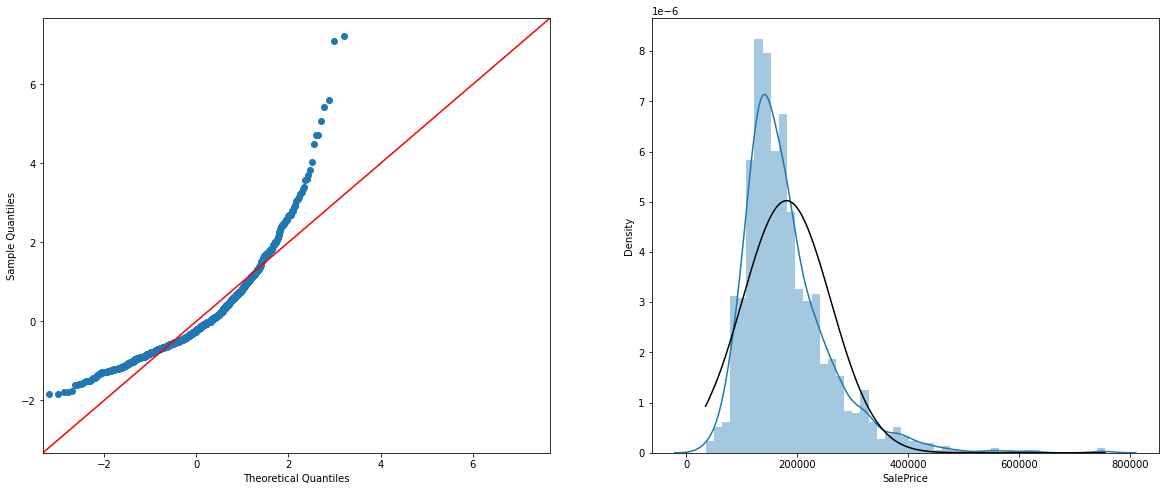

In [283]:
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

sm.qqplot(y, fit=True, line="45", ax = axes[0])

sns.distplot(y, kde=True, hist=True, ax = axes[1])

plt.plot(y, p, color='black', label=f'std approx with mu={round(mu)}, sigma={round(sigma)}')
plt.xlabel('SalePrice')

plt.show()

Видно, что распределение сильно отличается от нормального даже по тестам

Корреляция Спирмана работает на ранках распределений, то есть мы значениям случайных величин присваиваем ранк: банально то, какая величина по счету, если мы упорядочим всю выборку по убыванию. Затем мы просто считаем Пирсона для ранков двух переменных

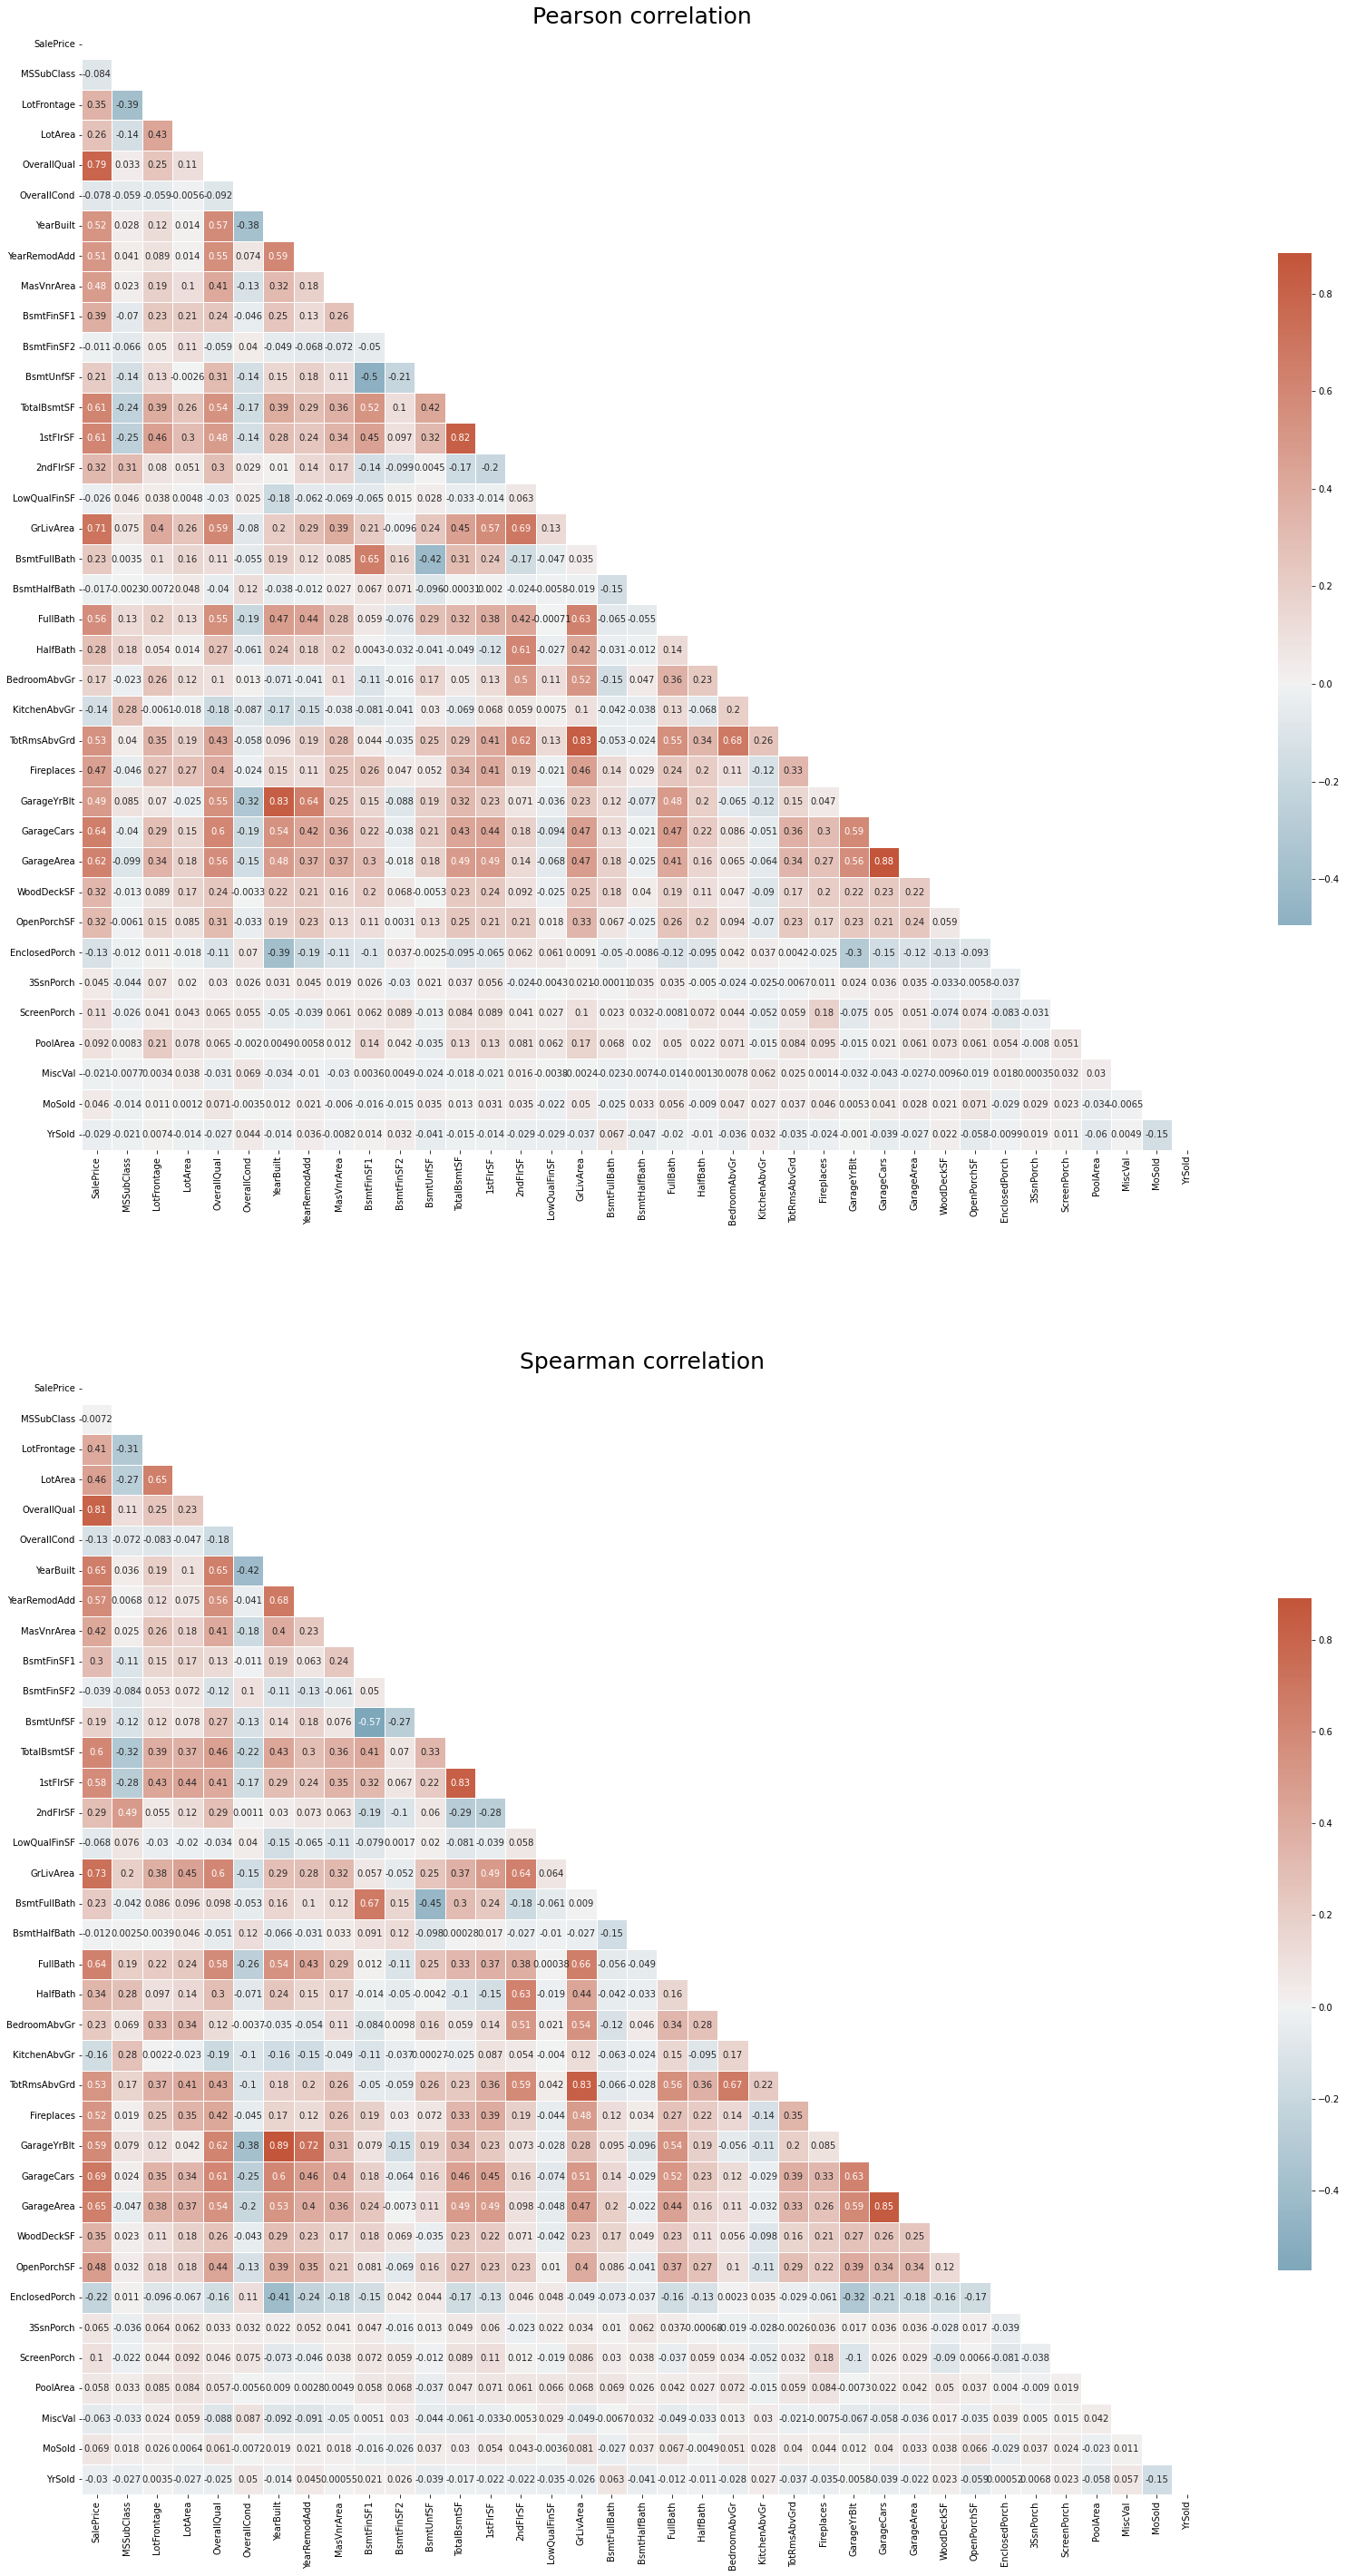

In [284]:
f, axes = plt.subplots(2, 1, figsize=(30, 50))

axes[0].set_title('Pearson correlation', fontsize=25)
axes[1].set_title('Spearman correlation', fontsize=25)

mat_pears = train_data.corr('pearson')
mask = np.triu(np.ones_like(mat_pears, dtype=bool))   # матрица симметричная - накладываем маску на верхнюю диагональ
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(
    mat_pears, mask=mask, cmap=cmap, center=0, annot = True,
    square=True, linewidths=.5, cbar_kws={"shrink": 0.6}, ax = axes[0]
            )

mat_spear = train_data.corr('spearman')
mask = np.triu(np.ones_like(mat_spear, dtype=bool))   # матрица симметричная - накладываем маску на верхнюю диагональ
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(
    mat_spear, mask=mask, cmap=cmap, center=0, annot = True,
    square=True, linewidths=.5, cbar_kws={"shrink": 0.6}, ax = axes[1]
            )

plt.show()

Какие фичи лучше всего коррелируют с таргетом:

In [285]:
top_pears = mat_pears['SalePrice'].sort_values()[-7:-1]
print(f'Pearson: \n-------\n{top_pears}')

top_spear = mat_spear['SalePrice'].sort_values()[-7:-1]
print(f'Spearman: \n-------\n{top_spear}')

Pearson: 
-------
1stFlrSF       0.605852
TotalBsmtSF    0.613581
GarageArea     0.623431
GarageCars     0.640409
GrLivArea      0.708624
OverallQual    0.790982
Name: SalePrice, dtype: float64
Spearman: 
-------
FullBath       0.635957
GarageArea     0.649379
YearBuilt      0.652682
GarageCars     0.690711
GrLivArea      0.731310
OverallQual    0.809829
Name: SalePrice, dtype: float64


Видно, что это две фичи имеющие дискретное распределение: OverallQual, GarageCars и фича с непрерывным распределением: GrLivArea

Корреляция Пирсона говорит о линейной зависимости, если она невысокая - это еще не значит, что две величины независимы.

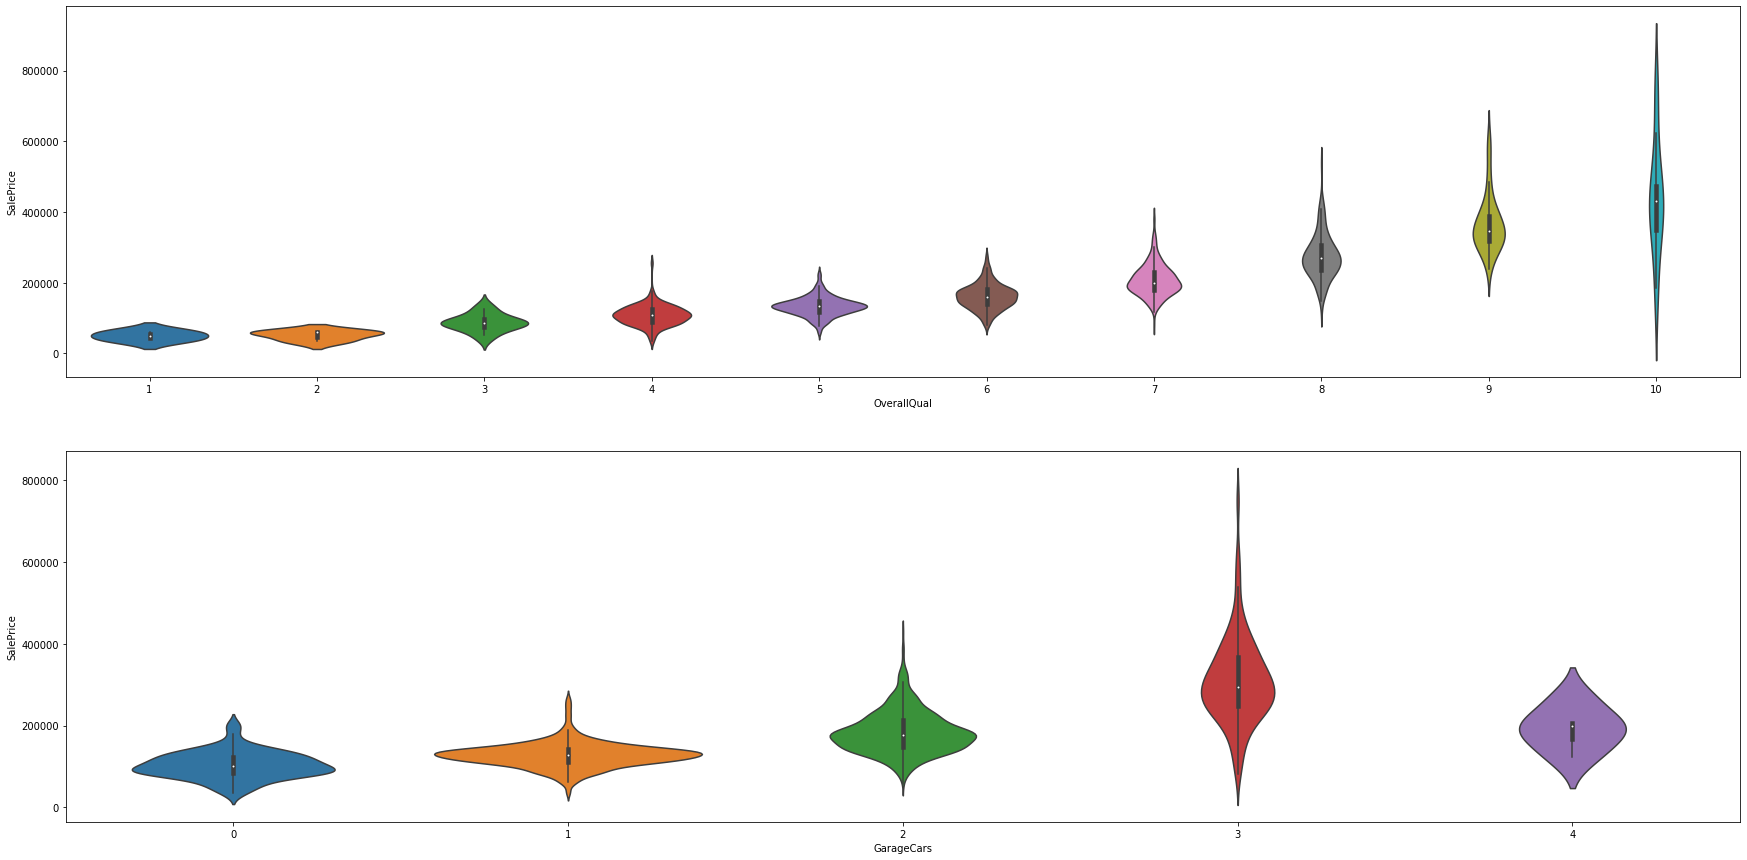

In [286]:
best_discrete = ['OverallQual', 'GarageCars']

fig, axes = plt.subplots(2, 1, figsize=(30, 15))

for (i, ax) in enumerate(axes):
    sns.violinplot(y='SalePrice', x=best_discrete[i], data=train_data, ax=ax)

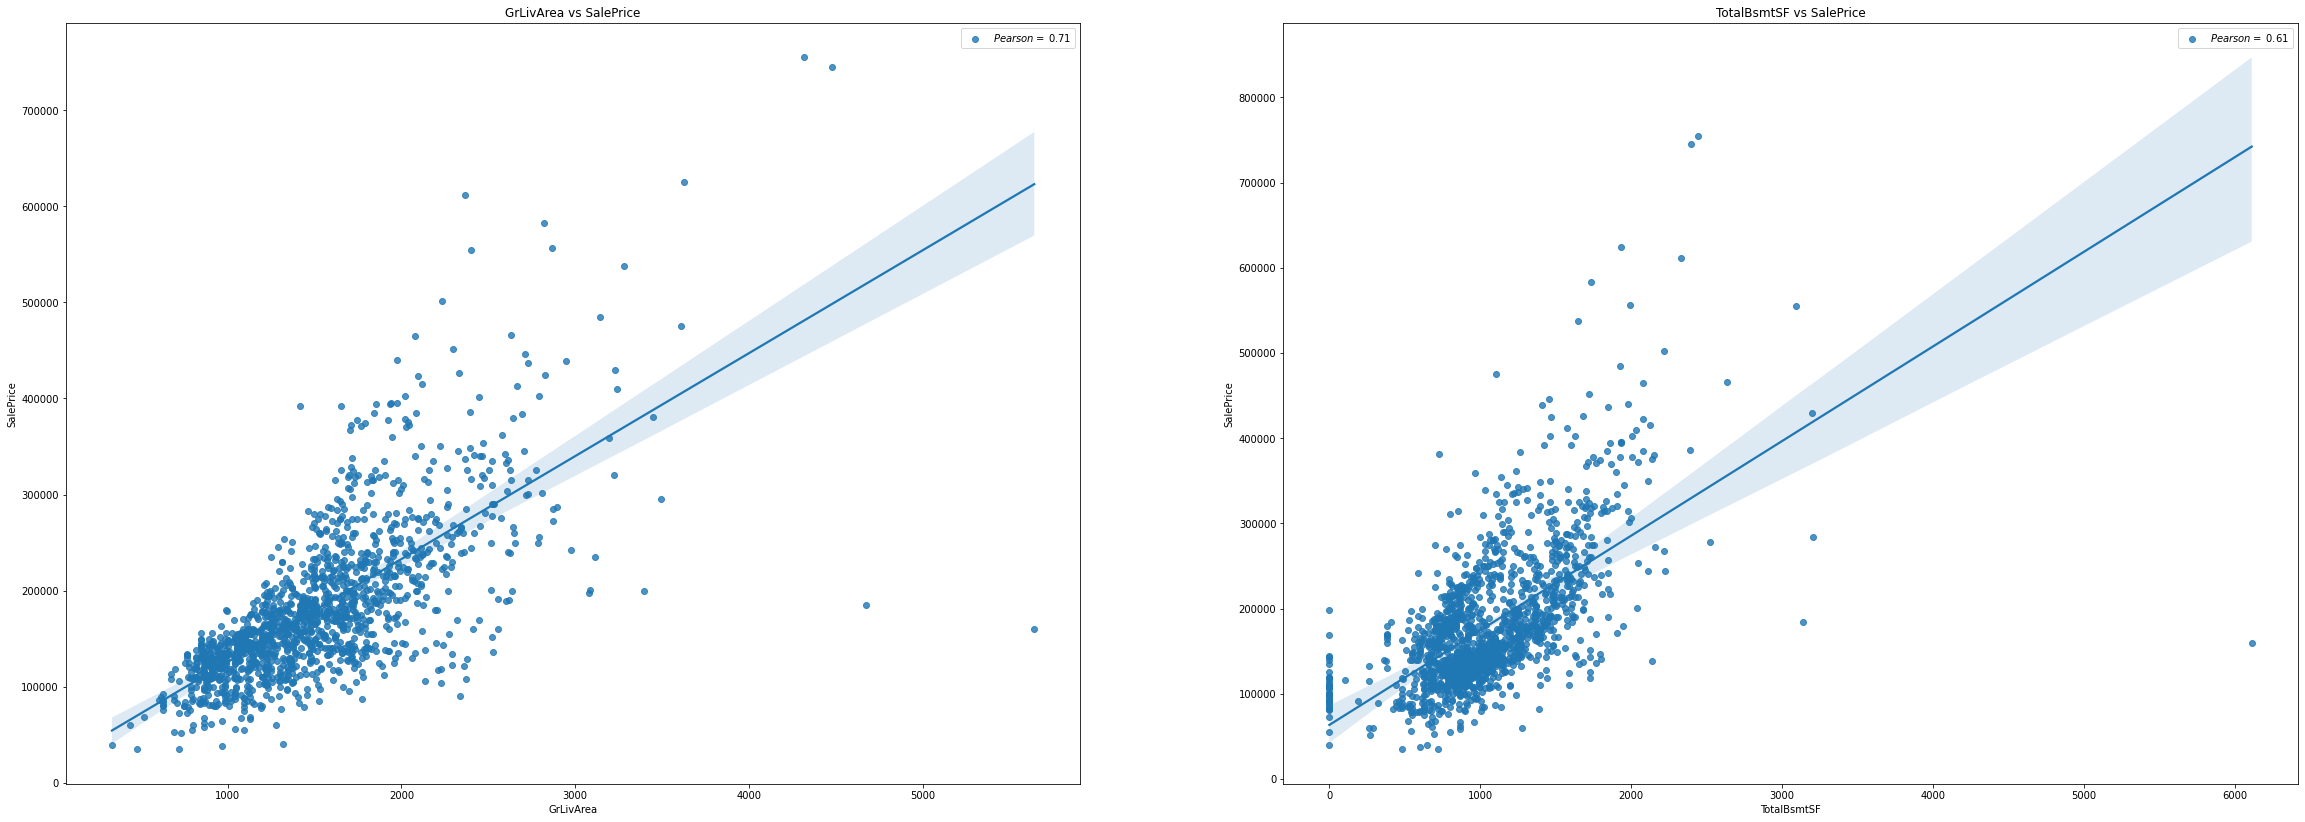

In [287]:
Pearson_GrLiv = mat_pears['SalePrice']['GrLivArea']
Pearson_TBSF = mat_pears['SalePrice']['TotalBsmtSF']

plt.figure(figsize = (40, 14))

plt.subplot(1, 2, 1)
sns.regplot(data=train_data, x = 'GrLivArea', y='SalePrice')    # plotting linear fit with sns.regplot
plt.title('GrLivArea vs SalePrice', fontsize = 12)
plt.legend(['$Pearson=$ {:.2f}'.format(Pearson_GrLiv)], loc = 'best')

plt.subplot(1, 2, 2)
sns.regplot(data=train_data, x = 'TotalBsmtSF', y='SalePrice')
plt.title('TotalBsmtSF vs SalePrice', fontsize = 12)
plt.legend(['$Pearson=$ {:.2f}'.format(Pearson_TBSF)], loc = 'best')


plt.show()

**There are features that have names with space in them:**

In [288]:
train_data.columns = train_data.columns.str.replace(' ', '')
test_data.columns = test_data.columns.str.replace(' ', '')

## Let's deal with NaNs

In [289]:
# To make work easier and preprocess test dataset the same way as train, I'll unite them into one df and separate target from it

train_X = train_data[features]

test_X = test_data[features]

data = pd.concat([train_X, test_X])
data

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2915,160,RM,21.0,1936,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,6,2006,WD,Normal
2916,160,RM,21.0,1894,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,4,2006,WD,Abnorml
2917,20,RL,160.0,20000,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,9,2006,WD,Abnorml


In [290]:
nan_df = pd.DataFrame(data.isna().sum(), columns=['Nan_amount'])

nan_df['%'] = (nan_df['Nan_amount'] / len(data)) * 100
nan_df = nan_df.sort_values('Nan_amount', ascending=False)

# Оставим только фичи, где много NaNов
nan_df = nan_df.loc[nan_df['Nan_amount'] != 0]
nan_df = nan_df.apply(func=lambda x: round(x, 2), axis=0)

nan_df['feature_name'] = nan_df.index

nan_df

,Nan_amount,%,feature_name
PoolQC,2909,99.66,PoolQC
MiscFeature,2814,96.40,MiscFeature
Alley,2721,93.22,Alley
Fence,2348,80.44,Fence
FireplaceQu,1420,48.65,FireplaceQu
LotFrontage,486,16.65,LotFrontage
GarageYrBlt,159,5.45,GarageYrBlt
GarageFinish,159,5.45,GarageFinish
GarageQual,159,5.45,GarageQual
GarageCond,159,5.45,GarageCond


In [291]:
data[nan_df.index].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 1 to 2919
Data columns (total 34 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PoolQC        10 non-null     object 
 1   MiscFeature   105 non-null    object 
 2   Alley         198 non-null    object 
 3   Fence         571 non-null    object 
 4   FireplaceQu   1499 non-null   object 
 5   LotFrontage   2433 non-null   float64
 6   GarageYrBlt   2760 non-null   float64
 7   GarageFinish  2760 non-null   object 
 8   GarageQual    2760 non-null   object 
 9   GarageCond    2760 non-null   object 
 10  GarageType    2762 non-null   object 
 11  BsmtExposure  2837 non-null   object 
 12  BsmtCond      2837 non-null   object 
 13  BsmtQual      2838 non-null   object 
 14  BsmtFinType2  2839 non-null   object 
 15  BsmtFinType1  2840 non-null   object 
 16  MasVnrType    2895 non-null   object 
 17  MasVnrArea    2896 non-null   float64
 18  MSZoning      2915 non-null 

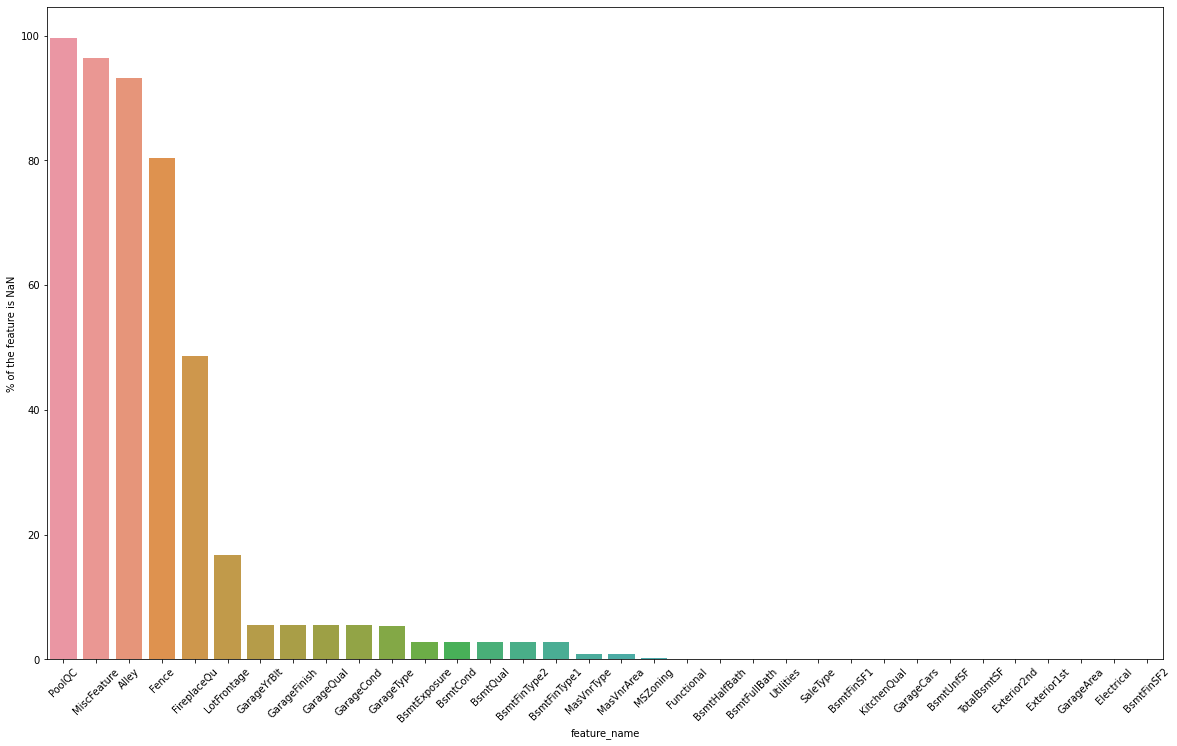

In [292]:
fig = plt.figure(figsize=(20, 12))

sns.barplot(x=nan_df['feature_name'], y=nan_df['%'])
plt.xticks(rotation=45)
plt.ylabel('% of the feature is NaN')

plt.show()

From data description we can fill the NaN for categorical features:

In [293]:
data['Functional'] = data['Functional'].fillna('Typ')
data['Electrical'] = data['Electrical'].fillna("SBrkr")
data['KitchenQual'] = data['KitchenQual'].fillna("TA")
data["PoolQC"] = data["PoolQC"].fillna("None")
data["Alley"] = data["Alley"].fillna("None")
data['FireplaceQu'] = data['FireplaceQu'].fillna("None")
data['Fence'] = data['Fence'].fillna("None")
data['MiscFeature'] = data['MiscFeature'].fillna("None")

# Здесь получается даталик необольшой может быть при заполнении модой при оценке качества модели, но думаю что это почти ничего страшного, ведь это мода
data['Exterior1st'] = data['Exterior1st'].fillna(data['Exterior1st'].mode()[0])
data['Exterior2nd'] = data['Exterior2nd'].fillna(data['Exterior2nd'].mode()[0])
data['SaleType'] = data['SaleType'].fillna(data['SaleType'].mode()[0])
data['MasVnrType'] = data['MasVnrType'].fillna(data['SaleType'].mode()[0])
data['Utilities'] = data['Utilities'].fillna(data['SaleType'].mode()[0])
data['MSZoning'] = data['MSZoning'].fillna(data['SaleType'].mode()[0])

In [294]:
for col in ('GarageArea', 'GarageCars'):
    data[col] = data[col].fillna(0)
        
for col in ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']:
    data[col] = data[col].fillna('None')
    
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    data[col] = data[col].fillna('None')

In [295]:
# Dropping features with a lot of nan, GarageYrBlt is just useless and has too much nan
data = data.drop(['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 'LotFrontage', 'GarageYrBlt'], axis='columns')

In [296]:
nan_df = pd.DataFrame(data.isna().sum(), columns=['Nan_amount'])

nan_df['%'] = (nan_df['Nan_amount'] / len(data)) * 100
nan_df = nan_df.sort_values('Nan_amount', ascending=False)

nan_df = nan_df.loc[nan_df['Nan_amount'] != 0]
nan_df = nan_df.apply(func=lambda x: round(x, 2), axis=0)

nan_df

,Nan_amount,%
MasVnrArea,23,0.79
BsmtFullBath,2,0.07
BsmtHalfBath,2,0.07
TotalBsmtSF,1,0.03
BsmtUnfSF,1,0.03
BsmtFinSF2,1,0.03
BsmtFinSF1,1,0.03


In [297]:
data[nan_df.index].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 1 to 2919
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   MasVnrArea    2896 non-null   float64
 1   BsmtFullBath  2917 non-null   float64
 2   BsmtHalfBath  2917 non-null   float64
 3   TotalBsmtSF   2918 non-null   float64
 4   BsmtUnfSF     2918 non-null   float64
 5   BsmtFinSF2    2918 non-null   float64
 6   BsmtFinSF1    2918 non-null   float64
dtypes: float64(7)
memory usage: 182.4 KB


Осталось заполнить только numerical колонки, при помощи KNN это сделаем

In [298]:
numerical_columns = []
categorical_columns = []

for col in data.columns:
    if data[col].dtype != object:
        numerical_columns.append(col)
    else:
        categorical_columns.append(col)

In [299]:
for col in categorical_columns:
    print(col, len(data[col].unique()))

MSZoning 6
Street 2
LotShape 4
LandContour 4
Utilities 3
LotConfig 5
LandSlope 3
Neighborhood 25
Condition1 9
Condition2 8
BldgType 5
HouseStyle 8
RoofStyle 6
RoofMatl 8
Exterior1st 15
Exterior2nd 16
MasVnrType 5
ExterQual 4
ExterCond 5
Foundation 6
BsmtQual 5
BsmtCond 5
BsmtExposure 5
BsmtFinType1 7
BsmtFinType2 7
Heating 6
HeatingQC 5
CentralAir 2
Electrical 5
KitchenQual 4
Functional 7
GarageType 7
GarageFinish 4
GarageQual 6
GarageCond 6
PavedDrive 3
SaleType 9
SaleCondition 6


Rest values are float values, so I'll fill them using kNN imputor, I am also using knowledge of features from test data, because I merged two datasets to fill train data better, it will only improve quality of the imputation

In [300]:
from sklearn.impute import KNNImputer
from sklearn.preprocessing import OneHotEncoder

In [301]:
imputer = KNNImputer(missing_values=np.nan)

# because this imputer works only with numercial values, I would need to create new df with encoded cat features to better fill up the values and then I'll need to go with cat values, because I'm going to use catboost.
# But it is too hard for this task, so I'll just fit KNN only on numerical features

filled_rows = imputer.fit_transform(data[numerical_columns])

In [302]:
filled_cols = filled_rows.T

In [303]:
filled_data = data[categorical_columns]
for (i, col) in enumerate(numerical_columns):
    filled_data.loc[:, col] = filled_cols[i]

/tmp/ipykernel_40100/1877654971.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filled_data.loc[:, col] = filled_cols[i]
/tmp/ipykernel_40100/1877654971.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filled_data.loc[:, col] = filled_cols[i]
/tmp/ipykernel_40100/1877654971.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs

In [304]:
filled_data = filled_data[numerical_columns + categorical_columns]

In [305]:
filled_data.isna().sum()

MSSubClass       0
LotArea          0
OverallQual      0
OverallCond      0
YearBuilt        0
YearRemodAdd     0
MasVnrArea       0
BsmtFinSF1       0
BsmtFinSF2       0
BsmtUnfSF        0
TotalBsmtSF      0
1stFlrSF         0
2ndFlrSF         0
LowQualFinSF     0
GrLivArea        0
BsmtFullBath     0
BsmtHalfBath     0
FullBath         0
HalfBath         0
BedroomAbvGr     0
KitchenAbvGr     0
TotRmsAbvGrd     0
Fireplaces       0
GarageCars       0
GarageArea       0
WoodDeckSF       0
OpenPorchSF      0
EnclosedPorch    0
3SsnPorch        0
ScreenPorch      0
PoolArea         0
MiscVal          0
MoSold           0
YrSold           0
MSZoning         0
Street           0
LotShape         0
LandContour      0
Utilities        0
LotConfig        0
LandSlope        0
Neighborhood     0
Condition1       0
Condition2       0
BldgType         0
HouseStyle       0
RoofStyle        0
RoofMatl         0
Exterior1st      0
Exterior2nd      0
MasVnrType       0
ExterQual        0
ExterCond   

In [306]:
data = filled_data

## Feature engineering:

Because trees are invariant to shifts, there is no point in normalizing data for tree models. But 1st layer of NN wants data to have $\mu = 0$ and $\sigma = 1$ so it will be more stable

If not using CV, then it is required to split train data into train + val parts to have a chance to see perfomance of the model on a val part. And then we should fit transformers on train data and apply it to both train and val sets

**This feature is a type of dwelling and is not numerical**

In [307]:
data['MSSubClass'] = data['MSSubClass'].apply(int).apply(str)

In [308]:
data["Age"] = (data["YrSold"] - data["YearBuilt"]).astype(int)

data["Renovate"] = (data["YearRemodAdd"] - data["YearBuilt"]).astype(int)

In [309]:
data = data.drop(
    ['YrSold',
    'YearBuilt',
    'YearRemodAdd'], axis='columns'
    )

**Let us get rid of skewness in numerical features. It is also possible to balance categorical feature if we unite certain categories into one or split one into many**

In [310]:
categorical_columns = list(filter(lambda x: data[x].dtype == object, data.columns))

numerical_columns = []

for col in data.columns:
    if data[col].dtype != object:
        numerical_columns.append(col)

In [311]:
for col in numerical_columns:
    transf_col = np.log1p(data[col])
    delta_skew = abs(stats.skew(transf_col)) - abs(stats.skew(data[col]))

    if delta_skew < 0:
        data.loc[:, col] = transf_col

/home/alphonse/anaconda3/envs/myenv/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/alphonse/anaconda3/envs/myenv/lib/python3.8/site-packages/scipy/stats/_stats_py.py:954: RuntimeWarning: invalid value encountered in subtract
  a_zero_mean = a - mean


And of course I need to spread data into X_train and X_test:

In [312]:
test_X.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,
1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [313]:
train_X.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal


In [314]:
train_X = data.iloc[:1460]
test_X = data.iloc[1460:]

## Creating a model:

In [315]:
y = pd.read_csv(train_path, index_col='Id')['SalePrice']

In [316]:
y = np.log(y)

In [317]:
import torch
from torchvision import transforms

from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm, tqdm_notebook

In [338]:
train_X.loc[:, 'SalePrice'] = y

train_X

/tmp/ipykernel_40100/1197707183.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_X.loc[:, 'SalePrice'] = y


,MSSubClass,SalePrice,LotArea,OverallQual,OverallCond,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,...,Functional,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,SaleType,SaleCondition,Age,Renovate
Id,,,,,,,,,,,,,,,,,,,,,
1,60,12.109011,9.042040,7.0,5.0,5.283204,6.561031,0.000000,150.0,856.0,...,Typ,Attchd,RFn,TA,TA,Y,WD,Normal,5,0
2,20,12.317167,9.169623,6.0,8.0,0.000000,6.886532,0.000000,284.0,1262.0,...,Typ,Attchd,RFn,TA,TA,Y,WD,Normal,31,0
3,60,11.849398,9.328212,7.0,5.0,5.093750,6.188264,0.000000,434.0,920.0,...,Typ,Attchd,RFn,TA,TA,Y,WD,Normal,7,1
4,70,12.429216,9.164401,7.0,5.0,0.000000,5.379897,0.000000,540.0,756.0,...,Typ,Detchd,Unf,TA,TA,Y,WD,Abnorml,91,55
5,60,11.870600,9.565284,8.0,5.0,5.860786,6.486161,0.000000,490.0,1145.0,...,Typ,Attchd,RFn,TA,TA,Y,WD,Normal,8,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,60,12.254863,8.976894,6.0,5.0,0.000000,0.000000,0.000000,953.0,953.0,...,Typ,Attchd,RFn,TA,TA,Y,WD,Normal,8,1
1457,20,12.493130,9.486152,6.0,6.0,4.787492,6.673298,5.099866,589.0,1542.0,...,Min1,Attchd,Unf,TA,TA,Y,WD,Normal,32,10
1458,70,11.864462,9.109746,7.0,9.0,0.000000,5.620401,0.000000,877.0,1152.0,...,Typ,Attchd,RFn,TA,TA,Y,WD,Normal,69,65


## Making submission: